In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np

DATA_PATH = 'workdir/data/contest_input.json'

json_file = json.load(open(DATA_PATH, 'r'))

In [8]:
couriers = json_file['couriers']

In [10]:
orders = json_file['orders']
orders_pickup_times_0 = np.array([(order['pickup_from'], order['pickup_to']) for order in orders])
orders_pickup_times = np.array([(((order['pickup_from'])), ((order['pickup_to']))) for order in orders])
orders_drop_times = np.array([(((order['dropoff_from'])), ((order['dropoff_to']))) for order in orders])
orders_from = np.array([(order['pickup_location_x'], order['pickup_location_y']) for order in orders])
orders_to = np.array([(order['dropoff_location_x'], order['dropoff_location_y']) for order in orders])
payments = np.array([(order['payment']) for order in orders])

delivery_dists = np.abs(orders_to - orders_from).sum(axis=1)

In [11]:
ord_from = [(a, b) for a, b in orders_from]
ord_to = [(a, b) for a, b in orders_to]

In [25]:
def manhattan_from(pos):
    return np.abs(orders_from - pos).sum(axis=1)

In [26]:
def calc_rub_dist(pos):
    dists_total = manhattan_from(pos) + delivery_dists
    rub_coeff = payments / dists_total
    
    return rub_coeff

In [61]:
def plot_moves(pos, cur_ids):
    from_points = orders_from[cur_ids]
    to_points = orders_from[cur_ids]

    plt.plot([pos[0]], [pos[1]], '*')
    plt.plot(from_points[:, 0], from_points[:, 1], '.', color='red')
    plt.plot(to_points[:, 0], to_points[:, 1], '.', color='blue')  

In [228]:
def manhattan(vector, point):
    return np.abs((vector - point)).sum(axis=1)

class Courier:
    def __init__(self, pos, time, orders_avaialble):
        self.pos = pos
        self.pickups = set()
        self.time = time
        
        self.orders_available = orders_avaialble
        
        self.reward = 0
        
    def get_step(self, n_steps):
        dists = manhattan(orders_from, self.pos)
        dists_to = delivery_dists
        time_to_arrive = self.time + dists
        
        can_arrive = time_to_arrive < orders_pickup_times[:, 1]
        can_arrive_before = (time_to_arrive + 30) > orders_pickup_times[:, 0]

        can_deliever = time_to_arrive + delivery_dists < orders_drop_times[:, 1]
        
        available = can_arrive * can_arrive_before * can_deliever * (self.orders_available == 1)
        
        if np.all(available == False):
            return []
        
        rub_dists = calc_rub_dist(self.pos)
        rubers = available * rub_dists + -1 * (1 - available)
        
        rub_argsorted = np.argsort(rubers)
        result = rub_argsorted[::-1][:n_steps]
        return result
    
    def move(self, order, target):
        if target == 'pickup':
            pos = orders_from[order]
        else:
            pos = orders_to[order]
        
        time = np.abs(self.pos - pos).sum()
        
        self.time += time
        self.pos = pos
        
        self.orders_available[order] = 0
        
        if target == 'pickup':
            if self.time > orders_pickup_times[order, 1]:
                self.reward = -10000000000
                return
                
            if self.time > orders_pickup_times[order, 0] and self.time < orders_pickup_times[order, 1]:
                self.pickups.add(order)
                self.time += 10
                return
                
            if self.time < orders_pickup_times[order, 0]:
                self.time = orders_pickup_times[order, 0] + 10
                self.pickups.add(order)
                return
            
        if target == 'dropoff':
            print(order, self.time, orders_drop_times[order, 1])
            if self.time > orders_drop_times[order, 1]:
                self.reward = -10000000000
                print('why?')
                return
            
            if self.time > orders_drop_times[order, 0] and self.time < orders_drop_times[order, 1]:
                self.pickups.remove(order)
                self.reward += orders[order]['payment']
                self.time += 10
                return
                
            if self.time < orders_drop_times[order, 0]:
                self.time = orders_drop_times[order, 0] + 10
                self.pickups.remove(order)
                self.reward += orders[order]['payment']
                return
            
    def show(self):
        print(self.time, self.pos, self.reward, self.pickups)
        
    def possible_moves(self, steps):
        possible_moves = [(i, 'pickup') for i in steps]
        possible_moves += [(i, 'dropoff') for i in self.pickups]
        
        return possible_moves

In [229]:
orders_from

array([[284, 235],
       [244, 262],
       [225, 141],
       ...,
       [162, 163],
       [233, 108],
       [243, 115]])

In [230]:
from copy import deepcopy

In [231]:
all_couriers = []

c0 = Courier(np.array((128, 128)), 360, np.ones(len(orders), dtype=int))
steps0 = c0.get_step(6)
for move_id, move_type in c0.possible_moves(steps0):
    c1 = deepcopy(c0)
    c1.move(move_id, move_type)
    
    steps1 = c1.get_step(6)
    for move_id1, move_type1 in c1.possible_moves(steps1):
        c1.move(move_id1, move_type1)
        
        all_couriers.append((move_id, move_id1, c1.reward, c1.time))

5747 679 960
6793 609 953
7113 759 1030
4991 564 765
7009 688 1005
7227 595 1107


In [233]:
all_couriers

[(5747, 289, 0, 398),
 (5747, 523, 0, 414),
 (5747, 7113, 0, 451),
 (5747, 7009, 0, 461),
 (5747, 6808, 0, 533),
 (5747, 6793, 0, 618),
 (5747, 5747, 541, 940),
 (6793, 4802, 0, 423),
 (6793, 7227, 0, 448),
 (6793, 7085, 0, 474),
 (6793, 4991, 0, 484),
 (6793, 6075, 0, 508),
 (6793, 5747, 0, 562),
 (6793, 6793, 600, 873),
 (7113, 7009, 0, 430),
 (7113, 7149, 0, 467),
 (7113, 5747, 0, 537),
 (7113, 2192, 0, 570),
 (7113, 5225, 0, 644),
 (7113, 7234, 0, 694),
 (7113, 7113, 650, 950),
 (4991, 7085, 0, 430),
 (4991, 6793, 0, 456),
 (4991, 7227, 0, 474),
 (4991, 4802, 0, 499),
 (4991, 1473, -10000000000, 547),
 (4991, 1654, -10000000000, 557),
 (4991, 4991, -9999999375, 685),
 (7009, 7113, 0, 440),
 (7009, 7149, 0, 477),
 (7009, 2260, 0, 496),
 (7009, 5747, 0, 566),
 (7009, 2192, -10000000000, 589),
 (7009, 5225, -10000000000, 663),
 (7009, 7009, -9999999375, 925),
 (7227, 6793, 0, 416),
 (7227, 4802, 0, 433),
 (7227, 7085, 0, 466),
 (7227, 4991, 0, 476),
 (7227, 6075, 0, 500),
 (7227, 5747

In [ ]:
orders[]

In [210]:
all_couriers

[(5747, 289, 0, 398),
 (5747, 523, 0, 414),
 (5747, 7113, 0, 451),
 (5747, 7009, 0, 461),
 (5747, 6808, 0, 533),
 (5747, 6793, 0, 618),
 (5747, 5747, 541, 940),
 (6793, 4802, 0, 423),
 (6793, 7227, 0, 448),
 (6793, 7085, 0, 474),
 (6793, 4991, 0, 484),
 (6793, 6075, 0, 508),
 (6793, 5747, 0, 562),
 (6793, 6793, 600, 873),
 (7113, 7009, 0, 430),
 (7113, 7149, 0, 467),
 (7113, 5747, 0, 537),
 (7113, 2192, 0, 570),
 (7113, 5225, 0, 644),
 (7113, 7234, 0, 694),
 (7113, 7113, 650, 950),
 (4991, 7085, 0, 430),
 (4991, 6793, 0, 456),
 (4991, 7227, 0, 474),
 (4991, 4802, 0, 499),
 (4991, 1473, -10000000000, 547),
 (4991, 1654, -10000000000, 557),
 (4991, 4991, -9999999375, 685),
 (7009, 7113, 0, 440),
 (7009, 7149, 0, 477),
 (7009, 2260, 0, 496),
 (7009, 5747, 0, 566),
 (7009, 2192, -10000000000, 589),
 (7009, 5225, -10000000000, 663),
 (7009, 7009, -9999999375, 925),
 (7227, 6793, 0, 416),
 (7227, 4802, 0, 433),
 (7227, 7085, 0, 466),
 (7227, 4991, 0, 476),
 (7227, 6075, 0, 500),
 (7227, 5747

In [ ]:
def courier_sym(pos):
    c = Courier(pos, 360, np.ones(len(orders), dtype=int))
    
    

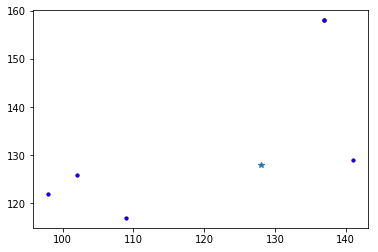

In [160]:
plot_moves(c.pos, c.get_step(6))

In [161]:
c.move(5747, 'pickup', )

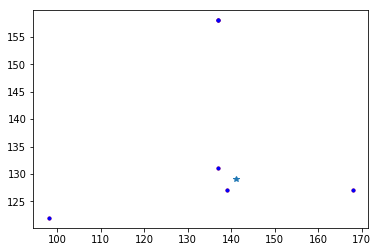

In [162]:
plot_moves(c.pos, c.get_step(6))

In [51]:
c.move(2192, 'pickup')

In [52]:
c.show()

371 [129 118] 0 {2192}


In [1046]:
def plot_moves(x, y, cur_ids):
    from_points = orders_from[cur_ids]
    to_points = orders_from[cur_ids]

    plt.plot([x], [y], '*')
    plt.plot(from_points[:, 0], from_points[:, 1], '.', color='red')
#    plt.plot(to_points[:, 0], to_points[:, 1], '.', color='blue')  

In [1047]:
def from_point_xy(i):
    return orders_from[i]

def to_point_xy(i):
    return orders_to[i]

In [1048]:
def single_step(x, y, used, cur_time=360, R=120, n_orders=8):
    dists = manhattan(orders_from, (x, y))
    dists_to = delivery_dists
    
    time_to_arrive = cur_time + dists + 10
    
    can_arrive = time_to_arrive < orders_pickup_times[:, 1]
    can_arrive_before = time_to_arrive + 10 > orders_pickup_times[:, 0]
    
    can_deliever = time_to_arrive + delivery_dists < orders_drop_times[:, 1]
    
    can_arrive_2 = can_arrive * can_arrive_before * can_deliever
    
    if np.all(can_arrive == False):
        return []
    
    near_dists = can_arrive_2 * dists + 1000000 * (1 - can_arrive)
    
    if np.all(near_dists == 1000000):
        return []
    
    pts = np.argsort(near_dists)[:n_orders]

    return pts

In [3]:
def manhattan(vector, point):
    return np.abs((vector - point)).sum(axis=1)

def courier_moves(x, y, cur_time, cur_step=0, used=None, max_step=15, n_vals=10):
    if cur_step > max_step:
        return np.zeros(0)

    current_to_use = single_step(x, y, used, cur_time, n_orders=n_vals)
    resulted_ids = list(current_to_use.copy())
    for cur_order in current_to_use:
        if used[cur_order] == 1:
            continue
        else:
            used[cur_order] = 1
            cur_x_f = orders_from[cur_order, 0]
            cur_y_f = orders_from[cur_order, 1]
            
            cur_x = orders_to[cur_order, 0]
            cur_y = orders_to[cur_order, 1]
            dist_manh = abs(cur_x - x) + abs(cur_y - y) #+ abs(cur_x_f - x) + abs(cur_y_f - y)
            
            resulted_ids = list(resulted_ids) + list(courier_moves(cur_x, cur_y, cur_time + dist_manh, cur_step + 1, used, max_step, max(1, n_vals // 2)))

    return resulted_ids

In [4]:
results = []

for cour in couriers:
    cou_x = cour['location_x']
    cou_y = cour['location_y']
    
    is_used = np.zeros(len(orders))
    cour = courier_moves(cou_x, cou_y, 360, used=is_used)
    results.append((cou_x, cou_y, cour))
    
    break

NameError: name 'couriers' is not defined

In [5]:
len(set(cour))

NameError: name 'cour' is not defined

In [6]:
inters = []

for _, _, i in results:
    for _, _, j in results:
        inters.append(len(set(i).intersection(j)))

In [1]:
def use_extra_orders(x, y, order_id):
    from_x, from_y = orders_from[order_id]
    to_x, to_y = orders_to[order_id]
    
    from_dist = abs(from_x - x) + abs(from_y - y)
    to_dist = abs(from_x - to_x) + abs(from_y - to_y)
    can_pick = (360 + from_dist) < orders_pickup_times[order_id, 1]
        
    drop_time = 360 + max(from_dist, orders_pickup_times[order_id, 0]) + 10 + to_dist
    can_drop = drop_time < orders_drop_times[order_id, 1]
    
    return can_drop and can_pick

In [2]:
for i, aaa in enumerate(results):
    _, _, cour = aaa
    courier = couriers[i]
    
    cour_x = courier['location_x']
    cour_y = courier['location_y']
    cr = list(set(cour))
    new_cr = [cr_val for cr_val in cr if use_extra_orders(cour_x, cour_y, cr_val)]
    
    print(len(cr), len(new_cr))
    
    
    ords = np.array(list(orders.values()))[list(set(cour))]

    o = open(f'outs/{i}.json', 'w')
    
    result_json = {'orders': ords.tolist(), 'couriers': [courier]}
    
    json.dump(result_json, o)
    
    o.close()
    
    break

NameError: name 'results' is not defined

In [1068]:
couriers[0]

{'courier_id': 1, 'location_x': 111, 'location_y': 5}

In [1069]:
ff = list(set(results[0][2]))

In [1070]:
np.array(list(orders.values()))[ff]

array([{'order_id': 16543, 'pickup_point_id': 46543, 'pickup_from': 330, 'pickup_to': 870, 'pickup_location_x': 263, 'pickup_location_y': 146, 'dropoff_point_id': 66543, 'dropoff_from': 818, 'dropoff_to': 930, 'dropoff_location_x': 115, 'dropoff_location_y': 226, 'payment': 511},
       {'order_id': 16035, 'pickup_point_id': 46035, 'pickup_from': 390, 'pickup_to': 1110, 'pickup_location_x': 74, 'pickup_location_y': 126, 'dropoff_point_id': 66035, 'dropoff_from': 1140, 'dropoff_to': 1200, 'dropoff_location_x': 289, 'dropoff_location_y': 63, 'payment': 439},
       {'order_id': 15525, 'pickup_point_id': 45525, 'pickup_from': 360, 'pickup_to': 750, 'pickup_location_x': 288, 'pickup_location_y': 155, 'dropoff_point_id': 65525, 'dropoff_from': 715, 'dropoff_to': 840, 'dropoff_location_x': 11, 'dropoff_location_y': 105, 'payment': 490},
       {'order_id': 16037, 'pickup_point_id': 46037, 'pickup_from': 390, 'pickup_to': 810, 'pickup_location_x': 272, 'pickup_location_y': 104, 'dropoff_point

In [1071]:
orders_drop_times[2992]

array([669, 780])

In [1072]:
is_used = np.zeros(len(orders))
single_step(111, 5, is_used)

array([3817, 3500, 3502, 3503, 1885, 3506, 3510, 1881])